## Implement Sliding Windows and Fir a Polynomial

![](images/sliding-window.png)

As shown in the previous animation, we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

### Split the histogram for the two lines

The first step we'll take is to split the histogram into two sides, one for each lane line.

```python
import numpy as np
import cv2
import matplotlib.pyplot as plt

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
```

Note that in the above, we also create `out_img` to help with visualizing our output later on.

### Set up windows and window hyperparameters

Our next step is to set a few hyperparameters related to our sliding windows, and set them up to iterate across the binary activations in the image. We have some base hyperparameters below, but don't forget to try out different values in your own implementation to see what works best!

```python
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set the minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped.shape[0]//nwindows)

# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = binary_warped.non_zero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
```

### Iterate through `nwindows` to track curvature

Now that we've set up what the windows look like and have a starting point, we'll want to loop for `nwindows`, with the given window sliding left or right if it finds the mean position of activated pixels within the window to have shifted.

You'll implement this part in the **quiz** below, but here's a few steps to get you started:
1. Loop through each window in `nwindows`
2. Find the boundaries of our current window. This is based on a combination of the current window's starting point(`leftx_current` and `rightx_current`), as well as the `margin` you set in the hyperparameters.
3. Use `cv2.rectangle` to draw these window boundaries onto our visualization image `out_img`. This is required for the quiz, but you can skip this step in practice if you don't need to visualize where the windows are.
4. Now that we know the boundaries of our window, find out which activated pixels from `nonzeroy` and `nonzerox` above actually fall into the window.
5. Append these to our lists `left_lane_inds` and `right_lane_inds`.
6. If the number of pixels you found in Step 4 are greater than your hyperparameter `minpix`, recenter our window (i.w. `leftx_current` or `rightx_current`) based on the mean position of these pixels.

### Fit a polynomial

Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line. First, we have couple small steps to ready our pixels.

```python
# Concatenate the arrays of indices (previously was a list of lists of pixels)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
```

We'll let you implement the function for the polynomial in the quiz below using `np.polyfit`.

```python
# Assuming we have 'left-fit' and 'right_fit' from 'np.polyfit' before
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
```

### Visualization

Once you reach this point, you're done! But here is how you can visualize the result as well:

```python
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
```

## Exercise

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

In [4]:
# Load the image
binary_warped = mpimg.imread('images/warped-example.jpg')

In [80]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set the mimimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixel in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
#         Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0,255,0), 2)
        
        good_left_inds = []
        good_right_inds = []
        
        for i in range(len(nonzeroy)):
            if (nonzeroy[i]>=win_y_low) and (nonzeroy[i]<=win_y_high):
                if (nonzerox[i]>=win_xleft_low) and (nonzerox[i]<=win_xleft_high):
                    good_left_inds.append(i)
                    
                if (nonzerox[i]>=win_xright_low) and (nonzerox[i]<=win_xright_high):
                    good_right_inds.append(i)
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [81]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Visualization
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img

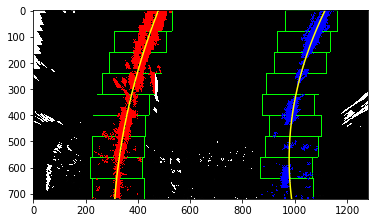

In [82]:
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)